__Data from:__ https://www.kaggle.com/code/yassineyahyaouii/nlp-sentiment-analysis-using-threads 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from gensim.models import Word2Vec
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Loading dataset
df = pd.read_csv('data/threads_review.csv')

In [3]:
# Types and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36943 entries, 0 to 36942
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               36943 non-null  int64  
 1   source                   36943 non-null  object 
 2   review_id                36943 non-null  object 
 3   user_name                36943 non-null  object 
 4   review_title             2000 non-null   object 
 5   review_description       36943 non-null  object 
 6   rating                   36943 non-null  int64  
 7   thumbs_up                34943 non-null  float64
 8   review_date              36943 non-null  object 
 9   developer_response       0 non-null      float64
 10  developer_response_date  0 non-null      float64
 11  appVersion               24855 non-null  object 
 12  laguage_code             36943 non-null  object 
 13  country_code             36943 non-null  object 
dtypes: float64(3), int64(2

In [4]:
# Viewing first five entries of the dataset, and other information
df.head()

,Unnamed: 0,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07 19:14:36,NaN,NaN,294.0.0.27.110,en,us
1,1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,NaN,NaN,NaN,en,us
2,2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,NaN,NaN,294.0.0.27.110,en,us
3,3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07 18:37:16,NaN,NaN,NaN,en,us
4,4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,5,0.0,2023-08-07 18:14:15,NaN,NaN,NaN,en,us


In [5]:
# To account for a positive or negative rating, reviews will be labelled through [0,1,2,3] as negative, [4,5] as positive
df['sentiment'] = df['rating'].apply(lambda x: 1 if x in [4, 5] else 0)

In [6]:
# Splitting dataset, train: 80%, test 20%
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [7]:
# With a larger data set, Word2Vec will be used to help reduce overfitting and possible word relationships

# Preprocessing and tokenizing reviews 
train_reviews = [review.split() for review in train_df['review_description']]
test_reviews = [review.split() for review in test_df['review_description']]

# Word2Vec model
vec_model = Word2Vec(sentences=train_reviews, vector_size=100, window=25, min_count=10, sg=0)

In [8]:
# Converting reviews to average with the model 
def review_to_vector(review):
    vectors = [vec_model.wv[word] for word in review if word in vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X_train = np.array([review_to_vector(review) for review in train_reviews])
X_test = np.array([review_to_vector(review) for review in test_reviews])

In [9]:
# Creating and training with XGBoost
model = xgb.XGBClassifier()
model.fit(X_train, train_df['sentiment'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [10]:
# Prediction on test set
pred = model.predict(X_test)

In [13]:
# Evaluating model
accuracy = accuracy_score(test_df['sentiment'], pred)
accuracy

0.7860332927324402

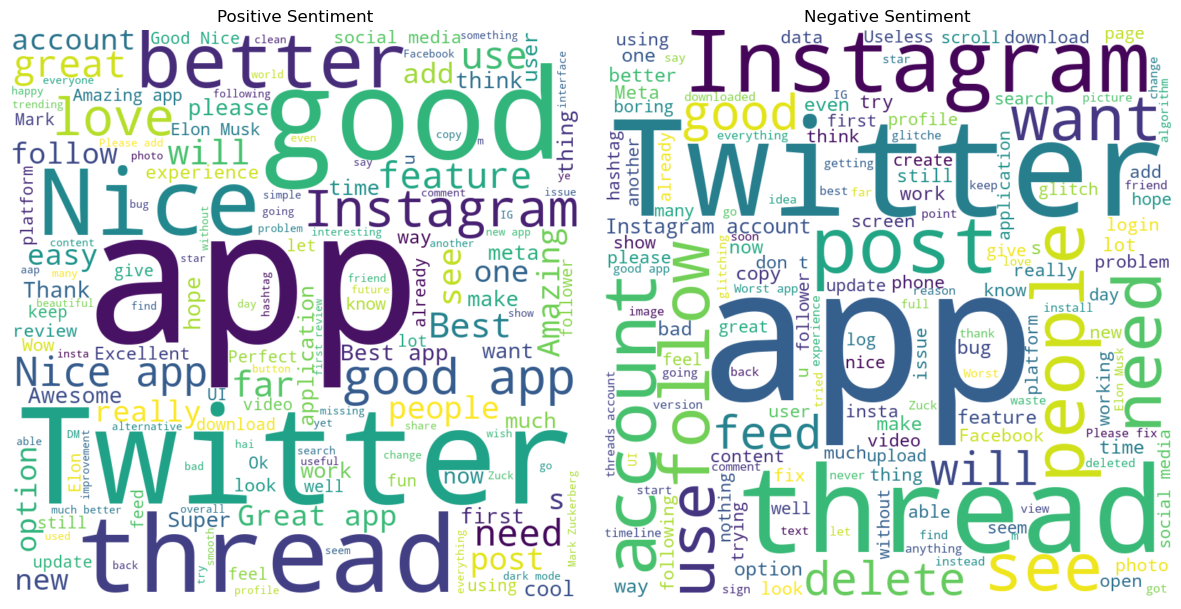

In [14]:
# Creating a visualization off WordCloud
positive_reviews = df[df['rating'].isin([4, 5])]['review_description']
negative_reviews = df[df['rating'].isin([0, 1, 2, 3])]['review_description']

# Combining both the reviews
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# WordCloud for positive
wordcloud_positive = WordCloud(width=800, height=800, 
                               background_color='white', max_words=150).generate(positive_text)

# WordCloud for negative
wordcloud_negative = WordCloud(width=800, height=800, 
                               background_color='white', max_words=150).generate(negative_text)

# Plotting WordCloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.tight_layout()
plt.show()

The current accuracy produced by XGBoost is __78.60%__, and this result came after some Hyperparameter Tuning. The WordCloud above shows the frequency of words posted within these reviews with the larger font being more frequent. Do note that there are words that have intersectionality between positive and negative, such as "_app, Instagram, Twitter_". The accuracy is a good start to this Sentiment Analysis, but for future iterations, more complex models such as TensorFlow or PyTorch should be considered to capture any intricate relationships within the data. Another method would be using the _"review_description"_ within Feature Engineering where the length and word frequency would be considered along with the review to help increase the accuracy. 